In [14]:
## import necessary packages
!pip install wbdata
!pip install CFEDemands
!pip install pint
!pip install requests
!pip install scipy

import ndb
import pandas as pd
import warnings
from  scipy.optimize import linprog as lp
import numpy as np
import wbdata 
import warnings
warnings.filterwarnings('ignore')

In [15]:
!pip install CFEDemands --upgrade
!pip install xarray

Requirement already up-to-date: CFEDemands in /anaconda3/lib/python3.6/site-packages (0.1.6.6)


## Nutritional Information

Utilized the ndb data set as well as Instacart to find prices nation-wide for the prices of 140+ different foods. These foods were gathered in the USDA food survey which analyzed household grocery aquisitions for varying lengths of time. The food was classified using the USDA 4-digit coding which is how we got our different items for pricing. Nutritional values were mapped to each food good as seen in chart below.

In [17]:
import ndb
import pandas as pd
import warnings

DFs = []
#for csv in CSVs:  # Uncomment to use a list of csv files as inputs
#  DFs.append(pd.read_csv(csv,dtype=str))

DFs.append(pd.read_csv("USFoodPrices.csv"))

df = pd.concat(DFs,ignore_index=True,sort=False)
# Some columns which ought to be numeric are actually str; convert them
df['Price'] = df['Price'].astype(float)
df['Quantity'] = df['Quantity'].astype(float)
df["Units"] = df["Units"].astype(str)
df["Value"] = df["Value"].dropna().astype(int).astype(str)
df["NDB"][df['Food'].str.contains("Milk shakes and other dairy drinks")] = str("01110")
df["NDB"] = df["NDB"].dropna()

prices_df = df

In [1058]:
values = df["Value"].tolist()
names = df["Food"].tolist()
value_name_dict = dict(zip(values,names))

In [1059]:
user = "atwater"
apikey = {'atwater':"ekh9KVmwQxokFmje0yDKJsSdG5PCuxWpXphJMEB3"}
age_list = ["C 1-3", "F 4-8", "M 4-8", "F 9-13", "M 9-13", "F 14-18", "M 14-18", "F 19-30", "M 19-30",\
            "F 31-50", "M 31-50", "F 51+", "M 51+"]
#http://www.censusscope.org/us/chart_age.html
age_breakdown = [6.82, 3.56, 3.74, 3.56, 3.74, 3.49, 3.69, 6.71, 6.92,\
                15.32, 15.15, 15.01, 12.32]
    
    
import ndb
D = {}

for food in  df.Food.tolist():
    try:
        NDB = df.loc[df.Food==food,:].NDB
        D[food] = ndb.ndb_report(apikey[user],NDB).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find NDB Code %s for food %s." % (food,NDB))
        

D = pd.DataFrame(D,dtype=float)

D = D.reindex(sorted(D.columns), axis=1)

D.head(10)

,Apple juice,Apples,Bacon,Bagels and English muffins,Bananas,"Beans, peas, legumes","Beef, excludes ground",Beer,Berries,"Biscuits, muffins, quick breads",...,Tortillas,"Turkey, duck, other poultry",Turnovers and other grain-based items,Vegetable juice,Vegetable mixed dishes,"White potatoes, baked or boiled",Wine,Yeast breads,"Yogurt, low-fat and nonfat","Yogurt, whole and reduced fat"
Caffeine,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
"Calcium, Ca",17.00,6.00,80.000,21.00,39.0,17.00,NaN,4.00,14.00,97.00,...,26.00,0.00,0.0,25.00,70.00,9.00,10.0,0.00,100.00,118.00
"Carbohydrate, by difference",46.67,14.29,1.890,53.68,67.5,3.33,3.57,2.97,12.14,44.66,...,46.51,3.57,75.0,5.83,26.29,15.54,3.8,42.86,9.33,14.12
Cholesterol,0.00,0.00,86.000,0.00,0.0,0.00,58.00,0.00,0.00,0.00,...,0.00,36.00,0.0,NaN,0.00,0.00,0.0,0.00,7.00,12.00
Energy,183.00,52.00,226.000,263.00,425.0,17.00,196.00,41.00,50.00,223.00,...,279.00,107.00,375.0,29.00,188.00,68.00,83.0,357.00,67.00,106.00
"Fatty acids, total monounsaturated",NaN,NaN,6.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.49,NaN,NaN,NaN,NaN,NaN,0.0,5.36,NaN,NaN
"Fatty acids, total polyunsaturated",NaN,NaN,4.699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.16,NaN,NaN,NaN,NaN,NaN,0.0,0.00,NaN,NaN
"Fatty acids, total saturated",0.00,0.00,4.520,0.00,12.5,0.00,4.46,NaN,0.00,0.00,...,0.00,0.00,0.0,NaN,0.70,0.00,0.0,7.14,NaN,1.76
"Fatty acids, total trans",0.00,0.00,0.184,0.00,0.0,0.00,NaN,0.00,0.00,0.00,...,0.00,0.00,0.0,NaN,0.00,0.00,NaN,0.00,NaN,0.00
"Fiber, total dietary",0.00,3.20,NaN,3.20,10.0,1.70,NaN,0.00,3.60,1.00,...,7.00,0.00,0.0,NaN,2.80,2.70,0.0,0.00,0.70,0.00


This deals with cleaning the charts.

In [1060]:
# Convert food quantities to NDB units
df['NDB Quantity'] = df[['Quantity','Units']].T.apply(lambda x : ndb.ndb_units(x['Quantity'],x['Units']))

# Now may want to filter df by time or place--need to get a unique set of food names.
df['NDB Price'] = df['Price']/df['NDB Quantity']

df.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Prices = df.groupby('Food')['NDB Price'].min()

## Regional Household Expenditures

As a starting point we considered different regional analysis to view how consumer purchases may vary based on the region. These were grouped based on four main regions: northeast, midwest, south and west. For each region we analyzed the average amount spent on food as well as other characteristics such as household size. 

The section below deals with separating the houses based on region by comparing two different CSVs and selecting only the appropiate rows. Additionally it does some changes of variable types for consistency later on.

In [1068]:
all_households = pd.read_csv('faps_household_puf.csv', dtype=str)

In [1069]:
northeast = all_households[all_households["region"] == "1"]
midwest = all_households[all_households["region"] == "2"]
south = all_households[all_households["region"] == "3"]
west = all_households[all_households["region"] == "4"]

In [1070]:
hh_choice = pd.read_csv('faps_fafhnutrient_puf.csv', dtype=str)

In [1071]:
hh_choice["food"] = hh_choice["usdafoodcat4"].map(value_name_dict)

In [1072]:
hh_choice['gramstotal'] = hh_choice['gramstotal'].astype(float)

In [1073]:
northeast_hh = hh_choice[hh_choice["hhnum"].isin(northeast["hhnum"])]
midwest_hh = hh_choice[hh_choice["hhnum"].isin(midwest["hhnum"])]
south_hh = hh_choice[hh_choice["hhnum"].isin(south["hhnum"])]
west_hh = hh_choice[hh_choice["hhnum"].isin(west["hhnum"])]

northeast_hh['gramstotal'] = northeast_hh['gramstotal'].astype(float)
midwest_hh['gramstotal'] = midwest_hh['gramstotal'].astype(float)
south_hh['gramstotal'] = south_hh['gramstotal'].astype(float)
west_hh['gramstotal'] = west_hh['gramstotal'].astype(float)

In [1074]:
import re
def numbers(value):
    return re.findall(r'\d+.\d+', value)
list_price = Prices.astype(str).apply(numbers)
def first_list(value):
    if len(value) >= 1:
        return float(value[0])
    else:
        return float(0)
corrected_prices = list_price.apply(first_list)

In [1075]:
hh_stats = pd.read_csv('faps_individual_puf.csv', dtype=str)
hh_stats["hhnum"] = hh_stats["HHNUM"]
hh_stats_number_of_people = len(hh_stats)
hh_stats_average_number_days = np.average(hh_stats["INITFINALDAYS"].astype(float))

In [1076]:
northeast_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(northeast["hhnum"])])
midwest_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(midwest["hhnum"])])
south_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(south["hhnum"])])
west_hh_number_of_people = len(hh_stats[hh_stats["HHNUM"].isin(west["hhnum"])])

In [1079]:
regions = [hh_choice, northeast_hh, midwest_hh, south_hh, west_hh]
values = []
households = []
number_of_people = []
monthly_income = []
measurement_time = []
for region in regions:
    food_df = pd.DataFrame()
    food_df["Foods"] = region.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])])
    households.append(len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]["hhnum"].unique()))
    monthly_income.append(np.average(all_households[all_households["hhnum"].isin(region["hhnum"])]['inchhavg_r'].astype(float)))
    number_of_people.append(len(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]))
    region['gramstotal'] = region['gramstotal'].astype(float)
    food_df["Price per Gram"] = corrected_prices / 100
    food_df["Amount Spent"] = food_df["Foods"] * food_df["Price per Gram"] 
    number_of_days = np.average(hh_stats[hh_stats["HHNUM"].isin(region["hhnum"])]["INITFINALDAYS"].astype(int))
    food_df["Amount Spent Daily"] = food_df["Amount Spent"] / number_of_days
    measurement_time.append(number_of_days)
    values.append(food_df["Amount Spent Daily"].sum())

values = np.round(values, 2)

## Regional Differences
We calculated the regional difference as well as for the total nation to see the differences below as well as proportions of values as they can serve as indicators for food expenditure habits.

In [1082]:
regions = ["Total", "Northeast", "Midwest", "South", "West"]
total_df = pd.DataFrame()
total_df["Region"] = regions
total_df["Amount Spent Daily ($)"] = values
total_df["Number of Households"] = households
total_df["Number of People"] = number_of_people
ratio = [int(p) / int(h) for p,h in zip(number_of_people, households)]
ratio = np.round(ratio, 2)
total_df["Average People per Household"] = ratio
total_df["Daily Income ($)"] = [np.round(int(p) / 30, 2) for p in monthly_income]
total_df["Proportion of Income Spent on Food (%)"] =  total_df["Amount Spent Daily ($)"] / total_df["Daily Income ($)"] * 100
total_df= total_df.set_index('Region')
total_df


,Amount Spent Daily ($),Number of Households,Number of People,Average People per Household,Daily Income ($),Proportion of Income Spent on Food (%)
Region,,,,,,
Total,5.80,4305,13078,3.04,130.53,4.443423
Northeast,5.83,717,2094,2.92,165.03,3.532691
Midwest,5.08,1058,2989,2.83,125.50,4.047809
South,6.89,1582,4722,2.98,112.10,6.146298
West,4.76,948,3273,3.45,140.90,3.378282


## Nutritional Thresholds
This section analyzes on a high level whether the current average diets within each region meet nutritional thresholds. This was also regionally grouped to highlight differences but still does not deal with the demand system and predictions created later. This is aimed to serve as a current overview of how heathily certain regions are eating.

In [1084]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = hh_choice.groupby("food")["gramstotal"].sum() / len(hh_stats) / 100
hh_choice['gramstotal'] = hh_choice['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
results = np.abs(b).align(D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (All Locations):")
print(tab)



With the following nutritional outcomes of interest (All Locations):
                                    Outcome  Recommendations
Calcium, Ca                      842.056704           1000.0
Carbohydrate, by difference      490.900674            130.0
Energy                          3525.863878           2000.0
Energy                          3525.863878           2400.0
Fiber, total dietary              18.666947             28.0
Folate, DFE                       46.168801            400.0
Iron, Fe                          13.988815              8.0
Magnesium, Mg                     36.105763            420.0
Niacin                             3.233847             16.0
Phosphorus, P                    214.493334            700.0
Potassium, K                    1168.727481           4700.0
Protein                          114.157212             56.0
Riboflavin                         0.440693              1.3
Sodium, Na                      5662.424236           2300.0
Thiamin        

In [1085]:
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]

In [1086]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = northeast_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(northeast_hh["hhnum"])]) / 100
northeast_hh['gramstotal'] = northeast_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (Northeast):")
print(tab)


With the following nutritional outcomes of interest (Northeast):
                                    Outcome  Recommendations
Calcium, Ca                      888.208912           1000.0
Carbohydrate, by difference      576.677925            130.0
Energy                          4032.149594           2000.0
Energy                          4032.149594           2400.0
Fiber, total dietary              19.019612             28.0
Folate, DFE                       57.083214            400.0
Iron, Fe                          14.676027              8.0
Magnesium, Mg                     33.366701            420.0
Niacin                             3.113074             16.0
Phosphorus, P                    189.875106            700.0
Potassium, K                    1145.200453           4700.0
Protein                          120.145413             56.0
Riboflavin                         0.428380              1.3
Sodium, Na                      6056.619350           2300.0
Thiamin            

In [1087]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = midwest_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(midwest_hh["hhnum"])]) / 100
midwest_hh['gramstotal'] = midwest_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (Midwest):")
print(tab)


With the following nutritional outcomes of interest (Midwest):
                                    Outcome  Recommendations
Calcium, Ca                     1008.763675           1000.0
Carbohydrate, by difference      591.055194            130.0
Energy                          4248.948894           2000.0
Energy                          4248.948894           2400.0
Fiber, total dietary              21.497283             28.0
Folate, DFE                       62.343860            400.0
Iron, Fe                          15.654134              8.0
Magnesium, Mg                     42.032283            420.0
Niacin                             4.029815             16.0
Phosphorus, P                    261.092795            700.0
Potassium, K                    1329.695007           4700.0
Protein                          133.149679             56.0
Riboflavin                         0.553152              1.3
Sodium, Na                      6847.487014           2300.0
Thiamin              

In [1088]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = south_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(south_hh["hhnum"])]) / 100
south_hh['gramstotal'] = south_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (South):")
print(tab)


With the following nutritional outcomes of interest (South):
                                    Outcome  Recommendations
Calcium, Ca                      969.510514           1000.0
Carbohydrate, by difference      522.255389            130.0
Energy                          3813.151159           2000.0
Energy                          3813.151159           2400.0
Fiber, total dietary              21.321479             28.0
Folate, DFE                       50.175838            400.0
Iron, Fe                          16.371394              8.0
Magnesium, Mg                     41.932481            420.0
Niacin                             3.934809             16.0
Phosphorus, P                    249.838210            700.0
Potassium, K                    1432.753136           4700.0
Protein                          131.113660             56.0
Riboflavin                         0.500746              1.3
Sodium, Na                      6345.099861           2300.0
Thiamin                

In [1089]:
food_df = pd.DataFrame()
food_df["Amount in Hectograms"] = west_hh.groupby("food")["gramstotal"].sum() / len(hh_stats[hh_stats["HHNUM"].isin(west_hh["hhnum"])]) / 100
west_hh['gramstotal'] = west_hh['gramstotal'].astype(float)
food_df["Price per Hectogram"] = corrected_prices
food_df["Amount Spent"] = food_df["Amount in Hectograms"] * food_df["Price per Hectogram"] 
fixed_D = D.loc[:,D.columns.to_series().isin(food_df.index.to_series()).tolist()]
results = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[1]
recommendation = np.abs(b).align(fixed_D.fillna(0) @ food_df[["Amount in Hectograms"]]["Amount in Hectograms"], 'inner')[0]
tab = pd.DataFrame()
tab["Outcome"] = results
tab["Recommendations"] = recommendation
print("\nWith the following nutritional outcomes of interest (West):")
print(tab)


With the following nutritional outcomes of interest (West):
                                    Outcome  Recommendations
Calcium, Ca                      795.170518           1000.0
Carbohydrate, by difference      485.153514            130.0
Energy                          3461.858808           2000.0
Energy                          3461.858808           2400.0
Fiber, total dietary              19.093250             28.0
Folate, DFE                       36.110717            400.0
Iron, Fe                          13.886444              8.0
Magnesium, Mg                     37.707507            420.0
Niacin                             2.797106             16.0
Phosphorus, P                    217.891902            700.0
Potassium, K                    1098.289919           4700.0
Protein                          111.732727             56.0
Riboflavin                         0.426054              1.3
Sodium, Na                      5486.607590           2300.0
Thiamin                 

## Demand Estimation Cleaning
This section deals with cleaning the household data in order to ready it for the data estimation. This works on grouping the expenditures per household and having the grams of each food organized in a way that will be used in the estimation system.

In [1097]:
hh_choice['gramstotal'] = hh_choice['gramstotal'].astype(float)

In [1098]:
households = all_households["hhnum"].tolist()
regions = all_households["region"].tolist()
household_region_dict = dict(zip(households,regions))

In [1099]:
hh_choice["region"] = hh_choice["hhnum"].map(household_region_dict)

In [1100]:
hi = hh_choice.groupby(["hhnum","region", "food"])["gramstotal"].sum().unstack('food')
like = hi.reset_index().rename_axis(None, axis=1)

In [1101]:
#like.insert(1, "year", [2013] * len(grouped))
like = like.rename(index=str, columns={"hhnum": "j", "year": "t", "region": "m"})

In [1102]:
grouped = hh_choice.groupby(["hhnum","region", "food"])["gramstotal"].sum().unstack('food')
grouped = grouped.reset_index().rename_axis(None, axis=1)
grouped.insert(1, "year", [2013] * len(grouped))
grouped = grouped.rename(index=str, columns={"hhnum": "j", "year": "t", "region": "m"})

## Household Data

This section deals with cleaning the household data in terms of number of people in the house and the age/sex breakdown. This is useful in being able to relate the size and demographics of household to the expenditure data in the estimation system.

In [1103]:
hh_stats = pd.read_csv('faps_individual_puf.csv', dtype=str)

In [1106]:
hh_stats = pd.read_csv('faps_individual_puf.csv', dtype=str)
hh_stats = hh_stats[["HHNUM", "SEX", "AGE_R"]]
hh_stats = hh_stats[hh_stats["AGE_R"] != 'D']
hh_stats['AGE_R'] = hh_stats['AGE_R'].astype(float)
def men_function(x):
    if float(x["AGE_R"]) >= 18 and x["SEX"] == '1':
        return 1
    return 0
def boy_function(x):
    if float(x["AGE_R"]) < 18 and x["SEX"] == '1':
        return 1
    return 0
def women_function(x):
    if float(x["AGE_R"]) >= 18 and x["SEX"] == '2':
        return 1
    return 0
def girl_function(x):
    if float(x["AGE_R"]) < 18 and x["SEX"] == '2':
        return 1
    return 0
#hh_stats["ADULT"] = hh_stats["AGE_R"].apply(over_eighteen)
hh_stats["Men"] = hh_stats.apply(men_function, axis=1)
hh_stats["Women"] = hh_stats.apply(women_function, axis=1)
hh_stats["Boys"] = hh_stats.apply(boy_function, axis=1)
hh_stats["Girls"] = hh_stats.apply(girl_function, axis=1)

In [1107]:
def household_size(x):
    return np.log(x["Men"] + x["Women"] + x["Boys"] + x["Girls"])

In [1158]:
hh_stats = hh_stats[["HHNUM", "Men", "Women", "Boys", "Girls"]]
hh_stats_grouped = hh_stats.groupby("HHNUM").sum().reset_index()
region_col = hh_stats_grouped["HHNUM"].map(household_region_dict)
hh_stats_grouped.insert(1, "region", region_col)
hh_stats_grouped.insert(1, "year", [2013] * len(hh_stats_grouped))
hh_stats_grouped["logHsize"] = hh_stats_grouped.apply(household_size, axis=1)
hh_stats_grouped = hh_stats_grouped.rename(index=str, columns={"HHNUM": "j", "year": "t", "region": "m"})
hh_stats_grouped['j'] = hh_stats_grouped['j'].astype(int)
hh_stats_grouped['t'] = hh_stats_grouped['t'].astype(int)
hh_stats_grouped['m'] = hh_stats_grouped['m'].astype(int)

Below is an example of what the cleaned household looks like entering demand system.

In [1159]:
hh_stats_grouped.head()

,j,t,m,Men,Women,Boys,Girls,logHsize
0,100012,2013,3,2,1,1,1,1.609438
1,100015,2013,3,1,0,0,0,0.000000
2,100024,2013,2,0,1,1,0,0.693147
3,100026,2013,3,2,1,0,0,1.098612
4,100028,2013,1,3,2,1,1,1.945910


## Setting Up Estimation System

This is the basic cleaning and set up of the estimation system.

In [1160]:
grouped['j'] = grouped['j'].astype(int)
grouped['t'] = grouped['t'].astype(int)
grouped['m'] = grouped['m'].astype(int)

In [1161]:
import pandas as pd
import numpy as np

x = grouped

z = hh_stats_grouped

# Take logs of expenditures; call this y
y = np.log(x.replace(0,np.nan).set_index(['j','t','m']))

z.set_index(['j','t','m'],inplace=True)

In [1162]:
prices_cleaned = prices_df["Price"].tolist() *4
food_names = prices_df["Food"].tolist() * 4
years = [2013] * len(food_names)
region = [1] * len(prices_df["Price"].tolist())
region.extend([2] * len(prices_df["Price"].tolist()))
region.extend([3] * len(prices_df["Price"].tolist()))
region.extend([4] * len(prices_df["Price"].tolist()))
prices_final = pd.DataFrame()
prices_final["t"] = years
prices_final["m"] = region
prices_final["i"] = food_names
prices_final["prices"] = prices_cleaned
prices_final_south = prices_final[prices_final['m'] == 3]
prices_final_west = prices_final[prices_final['m'] == 4]
prices_final.set_index(['t','m', 'i'],inplace=True)
prices_final_south.set_index(['t','m', 'i'],inplace=True)
prices_final_west.set_index(['t','m', 'i'],inplace=True)

In [1163]:
prices_final = prices_final.squeeze()
prices_final_south =prices_final_south.squeeze()
prices_final_west = prices_final_west.squeeze()

In [1164]:
z_south = z.iloc[z.index.get_level_values('m') == 3]
z_west = z.iloc[z.index.get_level_values('m') == 4]

In [1165]:
y_south = y.iloc[y.index.get_level_values('m') == 3]
y_west = y.iloc[y.index.get_level_values('m') == 4]

In [1166]:
import cfe
result = cfe.Result(y=y,z=z,prices = prices_final)

south = cfe.Result(y=y_south,z=z_south,prices = prices_final_south)
west = cfe.Result(y=y_west,z=z_west,prices = prices_final_west)

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [1167]:
result.get_reduced_form()
south.get_reduced_form()
west.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



In [1170]:
result.delta.to_dataframe().unstack('k').head()

delta                                \
k                                    Boys     Girls       Men     Women   
i                                                                         
Apple juice                      0.028696 -0.037768  0.025703 -0.023070   
Apples                           0.161655  0.213194  0.095476  0.087634   
Beans, peas, legumes            -0.053173 -0.123647 -0.092651 -0.089595   
Beef, excludes ground           -0.012953 -0.082544 -0.021752 -0.071837   
Biscuits, muffins, quick breads -0.035651 -0.005618  0.003974  0.016000   

                                           
k                                logHsize  
i                                          
Apple juice                      0.271712  
Apples                          -0.431094  
Beans, peas, legumes             0.330199  
Beef, excludes ground            0.156066  
Biscuits, muffins, quick breads  0.154234

Also the good-time constants $a_{it}$:



In [1171]:
result.a.to_dataframe().unstack('i').head()

a                                                       \
i      Apple juice    Apples Beans, peas, legumes Beef, excludes ground   
t    m                                                                    
2013 1    5.559769  5.233387             5.122763              5.088013   
     2    5.446038  5.319677             5.014240              5.272361   
     3    5.506452  5.285071             5.183730              5.153441   
     4    5.442662  5.255823             5.081373              5.165067   

                                                                \
i      Biscuits, muffins, quick breads Bottled water   Burgers   
t    m                                                           
2013 1                        4.681985      6.697891  5.308516   
     2                        4.591979      6.527038  5.461305   
     3                        4.728660      6.673994  5.486157   
     4                        4.661383      6.635897  5.468312   

                                                                     \
i      Burritos and tacos Cakes and pies Candy containing chocolate   
t    m                                                                
2013 1           6.024735       4.968167                   4.401958   
     2           5.864774       5.079270                   4.446212   
     3           6.067765       4.964940                   4.436482   
     4           6.229552       4.982456                   4.379136   

           ...                                \
i          ...      Sports and energy drinks   
t    m     ...                                 
2013 1     ...                      6.804743   
     2     ...                      6.895639   
     3     ...                      6.891433   
     4     ...                      6.848321   

                                                                               \
i      Stir-fry and soy-based sauce mixtures String beans Tap water       Tea   
t    m                                                                          
2013 1                              5.457854     4.581364  6.748600  6.765936   
     2                              5.445593     4.628199  6.828483  6.846014   
     3                              5.291183     4.557228  6.781508  7.081982   
     4                              5.396877     4.482208  6.805424  6.984176   

                                                                \
i      Tomato-based condiments Tortilla, corn, and other chips   
t    m                                                           
2013 1                3.807291                        4.110188   
     2                4.233572                        4.046643   
     3                4.358607                        4.272387   
     4                4.287492                        4.191528   

                                                                            
i      Vegetable mixed dishes White potatoes, baked or boiled Yeast breads  
t    m                                                                      
2013 1               5.405348                        4.937693     4.501830  
     2               5.333839                        5.043343     4.487551  
     3               5.389961                        5.042652     4.514949  
     4               5.367669                        4.881224     4.410087  

[4 rows x 67 columns]

In [1172]:
p = result.prices.sel(t=2013, m=1).copy()

p.to_dataframe().squeeze().head()

,m,t,prices
i,,,
Apple juice,1,2013,2.00
Apples,1,2013,4.10
"Beans, peas, legumes",1,2013,5.90
"Beef, excludes ground",1,2013,17.97
"Biscuits, muffins, quick breads",1,2013,5.19


In [1173]:
x=50

result.demands(x,p).head()

i
Apple juice                        0.501023
Apples                             0.259174
Beans, peas, legumes               0.017554
Beef, excludes ground              0.006867
Biscuits, muffins, quick breads    0.083389
Name: quantities, dtype: float64

## Demand Systems

We grouped all of the items by certain characteristics for later analysis. We considered more typically health and unhealthy options to see the effects of subsidizing and taxing both. Additionally, an extra focus was put on dairy later as our group had low amounts of Vitamin D and Calcium.

In [1174]:
dairy = ['Milk, whole', 'Milk, reduced fat', 'Milk, low fat', 'Milk, non fat', 'Flavored milk,whole', 'Flavored milk, reduced fat', 'Flavored milk, low fat', 'Milk shakes and other dairy drinks', 'Milk substitues', 'Cheese', 'Cottage/ricotta cheese', 'Yogurt, whole and reduced fat', 'Yogurt, low-fat and nonfat']
meat = ['Beef, excludes ground', 'Ground beef', 'Pork', 'Lamb, goat, game', 'Liver and organ meats', 'Chicken, whole pieces', 'Chicken patties, nuggets and tenders', 'Turkey, duck, and other poultry', 'Fish', 'Shellfish', 'Cold cuts and cured meats', 'Bacon', 'Frankfurters', 'Sausages', 'Meat mixed dishes', 'Poultry mixed dishes', 'Seafood mixed dishes']
unhealthy_meals = ['Egg rolls, dumplings, sushi', 'Burritos and tacos', 'Nachos', 'Other mexican mixed dishes', 'Pizza', 'Burgers', 'Frankfurter sandwiches', 'Chicken/turkey sandwiches', 'Egg/breakfast sandwiches', 'Other sandwiches']
grains = ['Rice', 'Pasta, noodles, cooked grains', 'Yeast breads', 'Rolls and buns', 'Bagels and English muffins',' Tortillas', 'Biscuits, muffins, quick breads', 'Pancakes, waffles, French Toast', 'Ready to eat cereal, higher sugar', 'Ready-to-eat cereal, lower sugar', 'Oatmeal', 'Grits and other cooked cereals']
unhealthy_snacks = ['Potato chips', 'Tortilla, corn, and other chips', 'Popcorn', 'Pretzels / snack mix', 'Crackers, excludes saltines', 'Saltine crackers', 'Cereal bars', 'Nutrition bars', 'Cakes and pies', 'Cookies and brownies', 'Doughnuts, sweet rolls, pastries', 'Candy containing chocolate', 'Candy not containing chocolate', 'Ice cream and frozen dairy desserts', 'Pudding', 'Gelatins, ices, sorbets', 'French fries and other fried potatoes']
fruits = ['Apples', 'Bananas', 'Grapes', 'Peaches and nectraines', 'Berries', 'Citrus fruits', 'Melons', 'Dried fruits', 'Other fruits and fruit salads', 'Tomatoes']
vegetables = ['Carrots', 'Other red and orange vegetables', 'Dark green vegetables, excludes lettuce', 'Lettuce and lettuce salads', 'String beans', 'Onions', 'Corn', 'Other starchy vegetables', 'Other vegetables and combinations', 'Vegetable mixed dishes', 'White potatoes, baked or boiled']
fruits_and_vegetables = fruits.copy()
fruits_and_vegetables.extend(vegetables.copy())

### Soft Drinks
One notably unhealthy option is soft drinks and thus we considered how the demand of soft drinks differed based on the South vs the West as there are historic eating differences between the two regions.

Text(0,0.5,'Price')

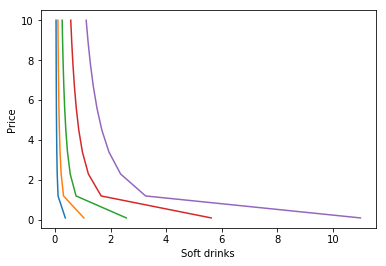

In [1175]:
#West
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

P = np.linspace(0.1,10,10)

def my_prices(p0,p=p):
    p = p.copy()
    p.loc['Soft drinks'] = p0
    return p

for x in [10,20,40,80,160]:
    plt.plot([south.demands(x,my_prices(p0))['Soft drinks'] for p0 in P],P)

plt.xlabel('Soft drinks')
plt.ylabel('Price')

Text(0,0.5,'Price')

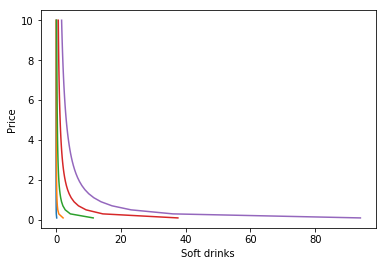

In [1176]:
#South
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

P = np.linspace(0.1,10,50)

def my_prices(p0,p=p):
    p = p.copy()
    p.loc['Soft drinks'] = p0
    return p

for x in [10,20,40,80,160]:
    plt.plot([west.demands(x,my_prices(p0))['Soft drinks'] for p0 in P],P)

plt.xlabel('Soft drinks')
plt.ylabel('Price')

### Unhealthy Snacks
Additoinaly we looked at the demand differences for typically unhealthy snacks as we believed there may be a vast difference in these two regions that could be useful for analysis.

Text(0,0.5,'Price')

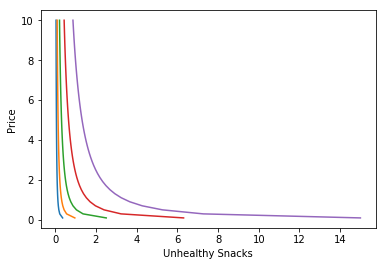

In [1177]:
#South
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

P = np.linspace(0.1,10,50)

goods = unhealthy_snacks

def my_prices_list(scale,goods = ["Bananas"], p=p):
    p = p.copy()
    for i in goods:
        try:
            p.loc[i] = scale * p.loc[i]
        except:
            continue
    return p

for x in [10,20,40,80,160]:
    plt.plot([np.sum(south.demands(x,my_prices_list(p0, goods))[goods])for p0 in P],P)

plt.xlabel('Unhealthy Snacks')
plt.ylabel('Price')

Text(0,0.5,'Price')

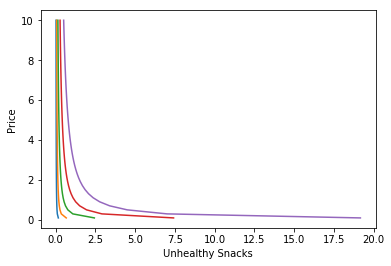

In [1178]:
#West
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

P = np.linspace(0.1,10,50)

goods = unhealthy_snacks

def my_prices_list(scale,goods = ["Bananas"], p=p):
    p = p.copy()
    for i in goods:
        try:
            p.loc[i] = scale * p.loc[i]
        except:
            continue
    return p

for x in [10,20,40,80,160]:
    plt.plot([np.sum(west.demands(x,my_prices_list(p0, goods))[goods])for p0 in P],P)

plt.xlabel('Unhealthy Snacks')
plt.ylabel('Price')

### Fruits and Vegetables
As a healthier option we analyzed all the fruits and vegetables for the demand systems as to see how the two differed in healthier choice preferances.

Text(0,0.5,'Price')

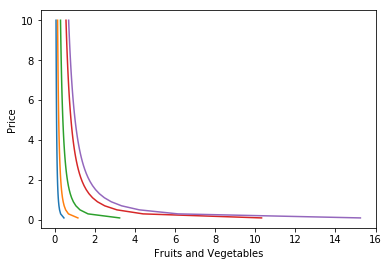

In [1179]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

P = np.linspace(0.1,10,50)

goods = fruits_and_vegetables

def my_prices_list(scale,goods = ["Bananas"], p=p):
    p = p.copy()
    for i in goods:
        try:
            p.loc[i] = scale * p.loc[i]
        except:
            continue
    return p

for x in [10,20,40,80,100]:
    plt.plot([np.sum(south.demands(x,my_prices_list(p0, goods))[goods])for p0 in P],P)

plt.xlabel('Fruits and Vegetables')
plt.ylabel('Price')

Text(0,0.5,'Price')

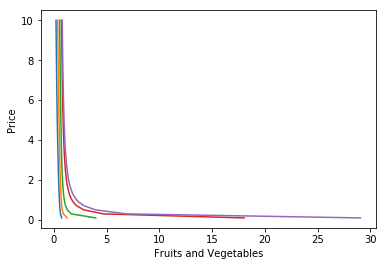

In [1183]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

P = np.linspace(0.1,10,50)

goods = fruits_and_vegetables

def my_prices_list(scale,goods = ["Bananas"], p=p):
    p = p.copy()
    for i in goods:
        try:
            p.loc[i] = scale * p.loc[i]
        except:
            continue
    return p

for x in [10,20,40,80,100]:
    plt.plot([np.sum(west.demands(x,my_prices_list(p0, goods))[goods])for p0 in P],P)

plt.xlabel('Fruits and Vegetables')
plt.ylabel('Price')

## Mapping to Nutrients

This section maps the items to the nutrient value to be put into the demand system.

In [1185]:
c =result.demands(x,p)

In [1186]:
fct = D.transpose()
fct.index.name = "Item name"
fct = fct.fillna(0)

In [1187]:
# Index of fct includes names of goods and also units.  Drop the latter:
try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # not a multiindex?

# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')

We use the diet minimums from the minimum cost diet to create the thresholds. And for the various boy,girl / man,woman we use the nutrition values of 9 - 13 year olds for the children ad 31 - 50 years old for the adults.

In [1188]:
rda = pd.read_csv('./diet_minimums.csv').copy()
rda = rda[["Nutrition", "M 9-13", "F 9-13", "M 31-50", "F 31-50"]]
rda = rda.set_index("Nutrition")

We next create the nutritional demand systems based off of nutrient values

In [1190]:
import cfe
import pandas as pd
import matplotlib.pyplot as plt

r=result
USE_GOOD = 'Milk, low fat' 
# Use prices, distribution of budgets from first round, first market:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Distribution of predicted total expenditures
xhat = r.get_predicted_expenditures().sum('i')
xhat = xhat.where(xhat>0,np.nan)

# Note selection of prices for first period and first market
p = r.prices.sel(t=t,m=m).fillna(1).copy()

def my_prices(p0,p=p,i=USE_GOOD):
    p = p.copy()
    p.loc[i] = p0
    return p


def nutrient_demand(x,p,r):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

# In first round, averaged over households and villages
zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize

# This matrix product gives minimum nutrient requirements for average
# household in first round
hh_rda = rda.replace('',0)@zbar

def nutrient_adequacy_ratio(x,p,r):
    return nutrient_demand(x,p,r)/hh_rda

This maps the amount of each of five key nutrients households are getting based on the budget. This is also broken down into all regions, west and south in order to see potential regional differences.

Text(0,0.5,'log nutrient')

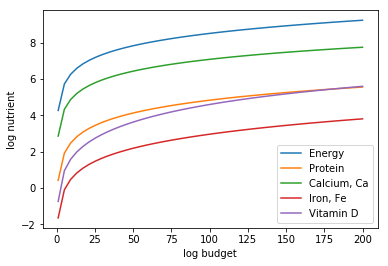

In [1191]:
import numpy as np
import matplotlib.pyplot as plt
X = np.linspace(1,200,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_demand(x,p,result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Text(0,0.5,'log nutrient')

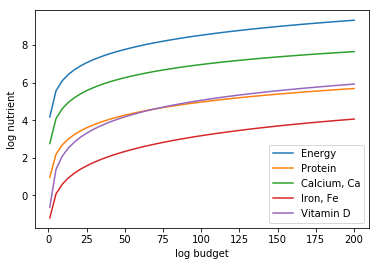

In [1192]:
import numpy as np
import matplotlib.pyplot as plt
X = np.linspace(1,200,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_demand(x,p,south))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Text(0,0.5,'log nutrient')

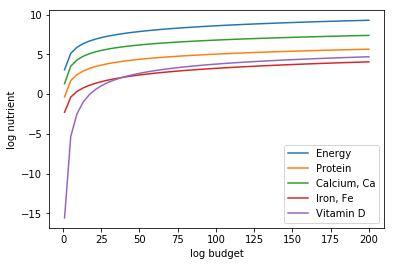

In [1193]:
import numpy as np
import matplotlib.pyplot as plt
X = np.linspace(1,200,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_demand(x,p,west))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

## Effect of Change in Dairy Prices
We aimed to see the affect that raising all dairy prices would have on the overall nutrition. Given the many food alternatives, certain aspects are unchanged but we see Calcium and Vitamin D have huge impacts

Text(0,0.5,'log nutrient')

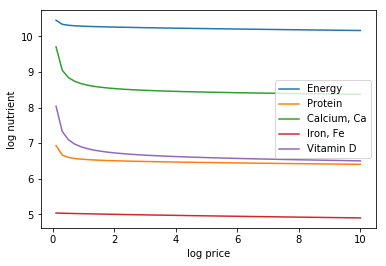

In [1195]:
P = np.linspace(.1,10,50)

x = 500

plt.plot(P,pd.concat({p0:np.log(nutrient_demand(x,my_prices_list(p0,goods=dairy), result))[UseNutrients] for p0 in P},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log price')
plt.ylabel('log nutrient')

## Household Nutritional Requirements

This aims to see whether households meet nutritional thresholds and if not what aspects are not being hit.

In [1196]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
x0 = xhat.sel(t=t,m=m).quantile(0.01,'j') # Budget (median household)
x0 = 100

## All Regions

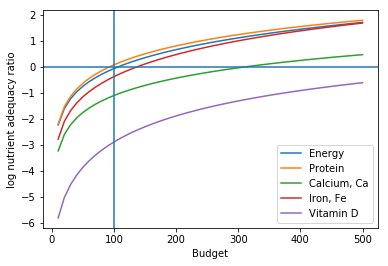

In [1197]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p, result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

## South

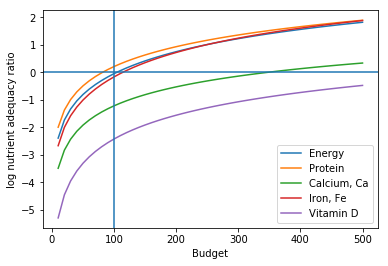

In [1198]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p, south))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

## West

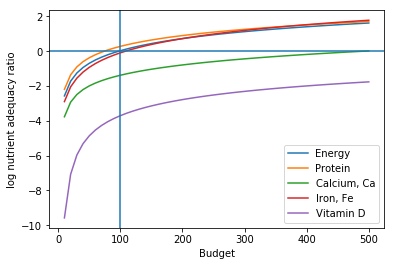

In [1200]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p, west))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

## Compensated Policy Experiment

This section looks at the Hicksian and Marshallian demand systems for a specific food – in this case apples. This is replicable with any food from our list and can be used to find the compensating variation.

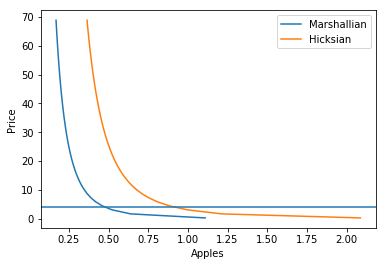

In [1201]:
P = np.linspace(ref_price/20,ref_price*10,50)

U0 = cfe.demands.marshallian.indirect_utility(x0,p,np.exp(r.alpha),r.beta,0)

plt.plot([r.demands(poorer_x,my_prices(p0,i="Apples"))["Apples"] for p0 in P],P)
plt.plot([r.demands(poorer_x,my_prices(p0,i="Apples"),type="Hicksian")["Apples"] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel("Apples")
plt.axhline(p.sel(i="Apples").values)
plt.legend(("Marshallian","Hicksian"))

In [1202]:
def compensating_variation(U0,p0,p1):
    x0 = cfe.demands.hicksian.expenditurefunction(U0,p0,np.exp(r.alpha),r.beta,0)
    x1 = cfe.demands.hicksian.expenditurefunction(U0,p1,np.exp(r.alpha),r.beta,0)

    return x1-x0

compensating_variation(U0,p,my_prices(1))

-4.242611369150083

## Subsidizing Dairy to  Meet Vitamin D requirements

An idea we had was to subsidize dairy to hopefully meet vitamin D requirements. We estabalished a 73% subsidy on dairy and saw dramatic improvements but still did not fully meet thresholds for nutrition.

#### 73% Subsidy Nutritional Adaquecy

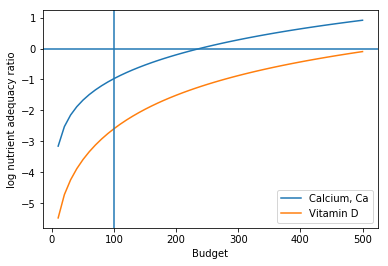

In [1001]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Calcium, Ca', 'Vitamin D']

def my_prices_list(scale,goods = ["Bananas"], p=p):
    p = p.copy()
    for i in goods:
        try:
            p.loc[i] = scale * p.loc[i]
        except:
            continue
    return p

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,my_prices_list(0.27, goods=dairy), result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

#### No Subsidy Nutritional Adaquecy

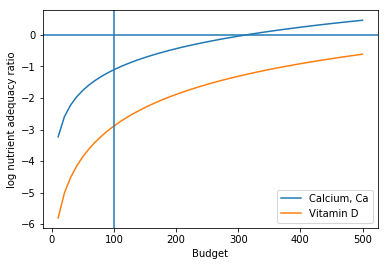

In [1181]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Calcium, Ca', 'Vitamin D']

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p, result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

## Relative Income

We measured how an increase in relative income would affect the overall nutriential adaquecy of diets.

### Doubling Relative Income

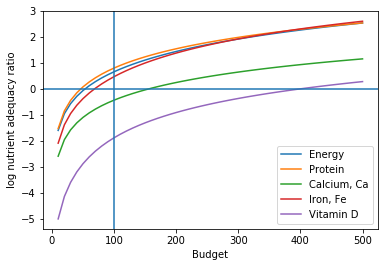

In [1205]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

def my_prices_subsidy(scale, p=p):
    p = p.copy()
    p = scale * p
    return p

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,my_prices_subsidy(0.5), result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

### Cutting all Prices by 20%

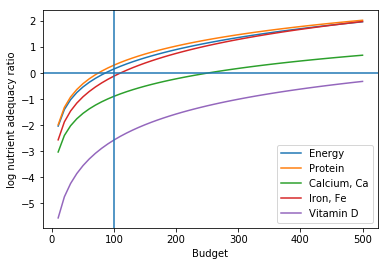

In [1206]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']

def my_prices_subsidy(scale, p=p):
    p = p.copy()
    p = scale * p
    return p

plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,my_prices_subsidy(0.8), result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

### Current Nutritional Thresholds

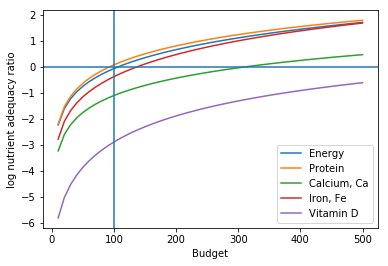

In [1207]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Energy', 'Protein', 'Calcium, Ca','Iron, Fe', 'Vitamin D']


plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p, result))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

### Calculating Betas



For each region we found betas of all foods to see how the food options varied based on the regions and corresponding beta values.

In [1209]:
#All Regions
result.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).head(10)

,beta
i,
Tomato-based condiments,1.342278
Sausages,1.174279
Yeast breads,1.104172
"Jams, syrups, toppings",1.043869
"Milk, reduced fat",1.018949
Cheese,1.000889
Pork,0.920667
"Beef, excludes ground",0.889091
"Beans, peas, legumes",0.886922


In [1210]:
#South
south.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).head(10)

,beta
i,
Sausages,1.428693
Corn,1.358592
"Beans, peas, legumes",1.250421
Yeast breads,1.072304
"White potatoes, baked or boiled",1.032191
Cookies and brownies,0.911600
"Milk, reduced fat",0.900944
Cakes and pies,0.895160
Eggs and omelets,0.895140


In [1211]:
#West
west.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).head(10)

,beta
i,
Lettuce and lettuce salads,1.607840
"Chicken, whole pieces",1.195538
"Beef, excludes ground",1.180215
Rolls and buns,1.143269
Yeast breads,1.119463
Cakes and pies,1.094314
Tea,1.090996
French fries and other fried potatoes,1.000226
Other vegetables and combinations,0.966408


## Betas for Unhealthy Food Options

We wanted to see the beta values for the unhealthy food options in each region to see how the elastisity varied.

In [1212]:
#All Regions
unhealthy_betas = result.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).reset_index()
unhealthy_betas = unhealthy_betas[unhealthy_betas['i'].isin(unhealthy_snacks)].set_index('i')
unhealthy_betas.head(10)

,beta
i,
Cookies and brownies,0.710055
Cakes and pies,0.647917
Candy not containing chocolate,0.528220
"Tortilla, corn, and other chips",0.470422
French fries and other fried potatoes,0.468275
Potato chips,0.425992
Ice cream and frozen dairy desserts,0.403412
Pretzels / snack mix,0.378012
"Doughnuts, sweet rolls, pastries",0.316152


In [1213]:
#South
unhealthy_betas = south.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).reset_index()
unhealthy_betas = unhealthy_betas[unhealthy_betas['i'].isin(unhealthy_snacks)].set_index('i')
unhealthy_betas.head(10)

,beta
i,
Cookies and brownies,0.911600
Cakes and pies,0.895160
French fries and other fried potatoes,0.653918
"Tortilla, corn, and other chips",0.582373
"Doughnuts, sweet rolls, pastries",0.555570
Pretzels / snack mix,0.408442
Potato chips,0.291644


In [1214]:
#West
unhealthy_betas = west.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).reset_index()
unhealthy_betas = unhealthy_betas[unhealthy_betas['i'].isin(unhealthy_snacks)].set_index('i')
unhealthy_betas.head(10)

,beta
i,
Cakes and pies,1.094314
French fries and other fried potatoes,1.000226
Cookies and brownies,0.695474
"Doughnuts, sweet rolls, pastries",0.356122


## Betas for Healthy Food Options

We wanted to see the beta values for the healthy food options in each region to see how the elastisity varied.

In [1215]:
#All Regions
healthy_betas = result.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).reset_index()
healthy_betas = healthy_betas[healthy_betas['i'].isin(fruits_and_vegetables)].set_index('i')
healthy_betas.head(10)

,beta
i,
"White potatoes, baked or boiled",0.866962
Corn,0.786636
Lettuce and lettuce salads,0.663319
Other vegetables and combinations,0.658964
String beans,0.627803
Carrots,0.579664
Other fruits and fruit salads,0.535893
Apples,0.335808
Vegetable mixed dishes,0.304474


In [1217]:
#South
healthy_betas = south.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).reset_index()
healthy_betas = healthy_betas[healthy_betas['i'].isin(fruits_and_vegetables)].set_index('i')
healthy_betas.head(10)

,beta
i,
Corn,1.358592
"White potatoes, baked or boiled",1.032191
String beans,0.830499
Other fruits and fruit salads,0.694348
Other vegetables and combinations,0.658238
Apples,0.424039
Lettuce and lettuce salads,0.295017


In [1219]:
#West
healthy_betas = west.get_beta().to_dataframe().sort_values(by=["beta"], ascending=False).reset_index()
healthy_betas = healthy_betas[healthy_betas['i'].isin(fruits_and_vegetables)].set_index('i')
healthy_betas.head(10)

,beta
i,
Lettuce and lettuce salads,1.607840
Other vegetables and combinations,0.966408
Other fruits and fruit salads,0.712566
Apples,0.085743
